# Import Modules

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as Model #Model module builds basic parts of the advection diffusion PDE problem, combines other classes into full model
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as MFModel

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointAdvectionDiffusionModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
#from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindSimple #Wind model

#Plotting tools
import matplotlib.pyplot as plt

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which includes the start and end times of the observation period and the x and y locations that the observation was taken at. Consider an array of four sensors in a grid that each take two time averaged readings. 

In [2]:
X = np.asarray([[2,3,3,3],[2,3,3,7],[2,3,7,3],[2,3,7,7], #[t_lower,t_upper,x_location,y_location]
               [8,9,3,3],[8,9,3,7],[8,9,7,3],[8,9,7,7]])

In [3]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,10) # x locations
yloc=np.linspace(1,9,10) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.01 # upper time

sensors = FixedSensorModel(X,0.01) # establish sensor model arguments are sensor locations and spatial averaging

/tmp/ipykernel_9646/2046575662.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xk" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X[:,2],X[:,3],'xk',markersize=15,color='b')


Text(0.5, 1.0, 'Sensor Locations')

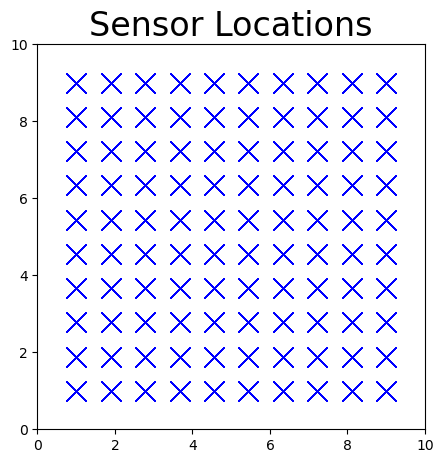

In [4]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(X[:,2],X[:,3],'xk',markersize=15,color='b')
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Sensor Locations",fontsize=24)

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [5]:
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging (second argument)

# Forward Model Example

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a 10x10x10 grid in space and time.

### Establish forward model parameters

In [6]:
k_0 = 0.01 #Diffusion coefficient
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
kForward = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [300,50,50] # grid size for time, x and y
#u=[]
#u.append(np.ones(res)*0.01) #x direction wind
#u.append(np.ones(res)*0.01) # y direction wind
#windmodel=WindFixU(u) # establish fixed wind model
windmodel=WindSimple(0.01,0.03)

### Initialise model and calculate ground truth source, concentration and observations

Here we use a constant source at a fixed location, but include code (commented out) for a source term calculated by approximating a gaussian process with an EQ kernel. Any source of the right dimensions can be used to simulate the forward problem.

In [7]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0) #initiate PDE model to build concentration

delta, Ns = m.getGridStepSize() # useful numbers!
dt = delta[0]
#z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
#sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
sourceGT = np.zeros(m.resolution)
sourceGT[:,7:11,7:11] = 10.0 # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

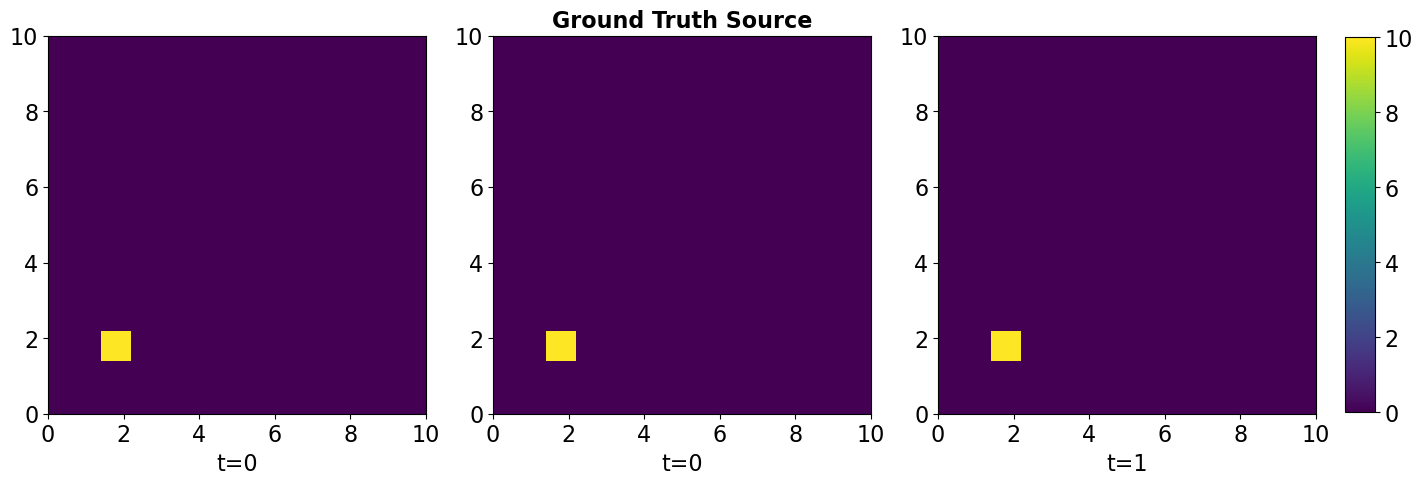

In [8]:
a=np.floor(np.min((np.min(sourceGT[[0,28,49]]))))
b=np.ceil(np.max((np.max(sourceGT[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source'],[sourceGT]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

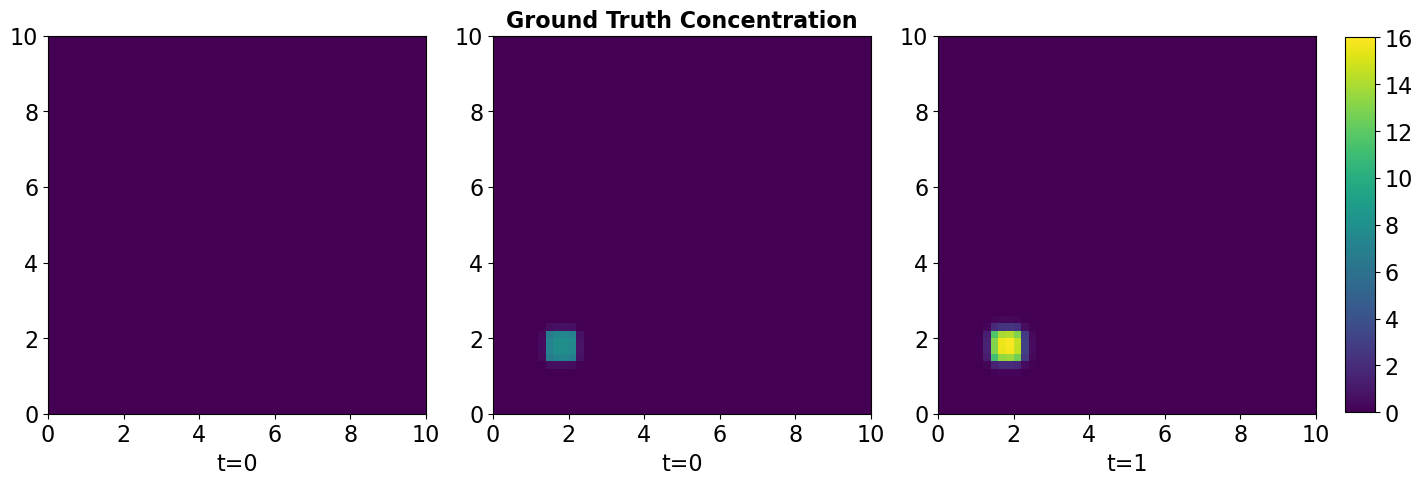

In [9]:
a=np.floor(np.min((np.min(concTrain[[0,28,49]]))))
b=np.ceil(np.max((np.max(concTrain[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Concentration'],[concTrain]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

# Inverse Problem Example

In [10]:
N_feat =300 #Number of features used to infer the source
kInverse = EQ(2, 2.0) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=0) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeResponse(sourceInfer) # Generates estimated concentration from inferred source



Computing SS...
Inverting SS...
Computing meanZ
Done


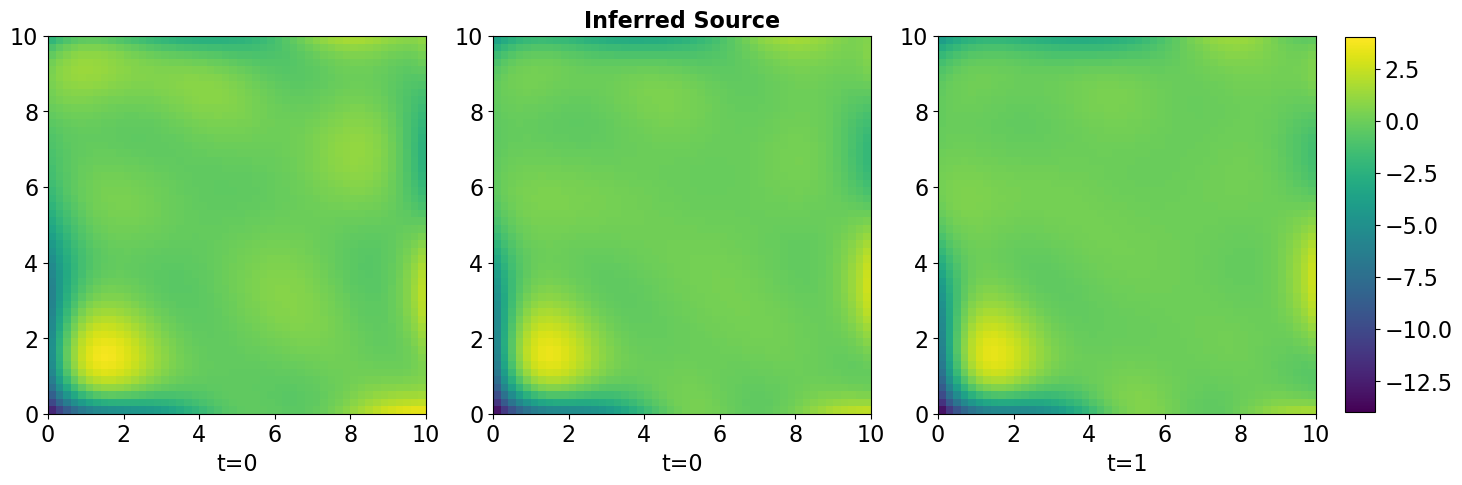

In [11]:
def plot_timeslices(arr,fulltitle):
    a=np.floor(np.min((np.min(arr[[0,28,49]]))))
    b=np.ceil(np.max((np.max(arr[[0,28,49]]))))
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure()

    ploti = 0
    for title, data in zip([fulltitle],[arr]):
        for t in [0,24,39]:
            ploti+=1
            plt.subplot(1,3,ploti)
            im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
            time = t*dt
            plt.xlabel("t=%d" % time,fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.clim(a,b)


            tick_font_size = 16
            if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
            #if ploti % 3 == 3:
            #    plt.colorbar(im1,fraction=0.046, pad=0.04)

    fig.tight_layout(rect=[0.1, 0.2, 1, 1])

    cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
    cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
    #cbar = plt.colorbar(im3,fraction=0.046)
    tick_font_size = 16
    cbar.ax.tick_params(labelsize = tick_font_size)
    plt.show()
    
plot_timeslices(sourceInfer,"Inferred Source")

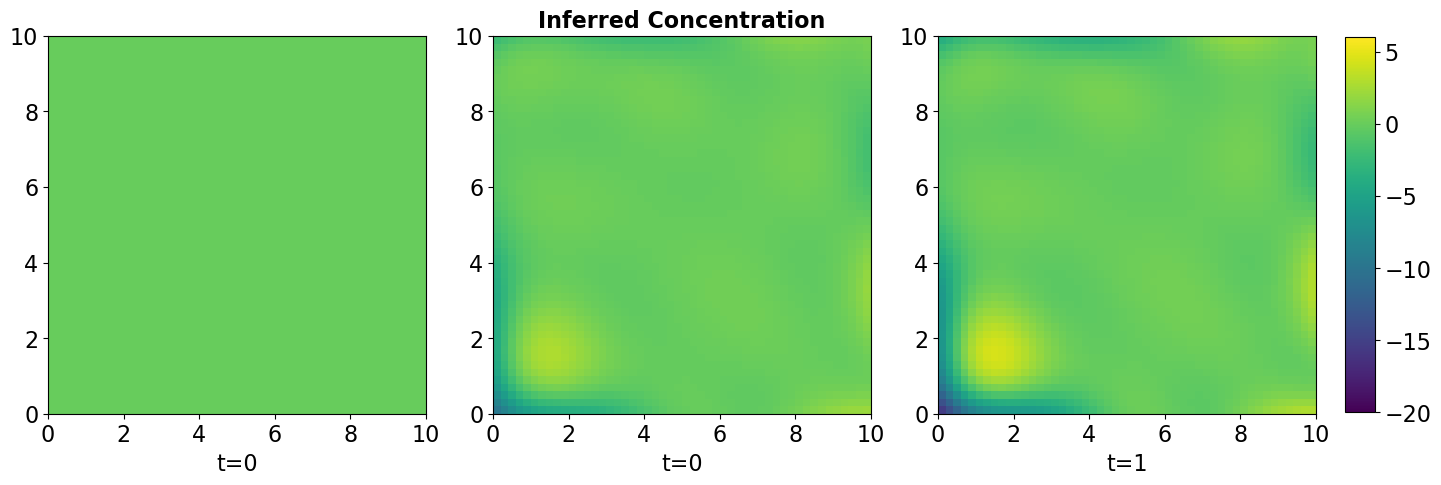

In [12]:
plot_timeslices(concInfer,"Inferred Concentration")

# Using the MeshFree Model

In [13]:
mMFInfer = MFModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
mMFInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mMFInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mMFInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution


Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


In [15]:
#Compute source grid
coords = mMFInfer.coords.transpose([1,2,3,0])
#sources = np.array([mMFInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sources = mMFInfer.computeSourceFromPhiInterpolated(meanZ)
sourcesmean = np.mean(sources,0)
sourcesvar = np.var(sources,0)




cache miss, computing source from phi...


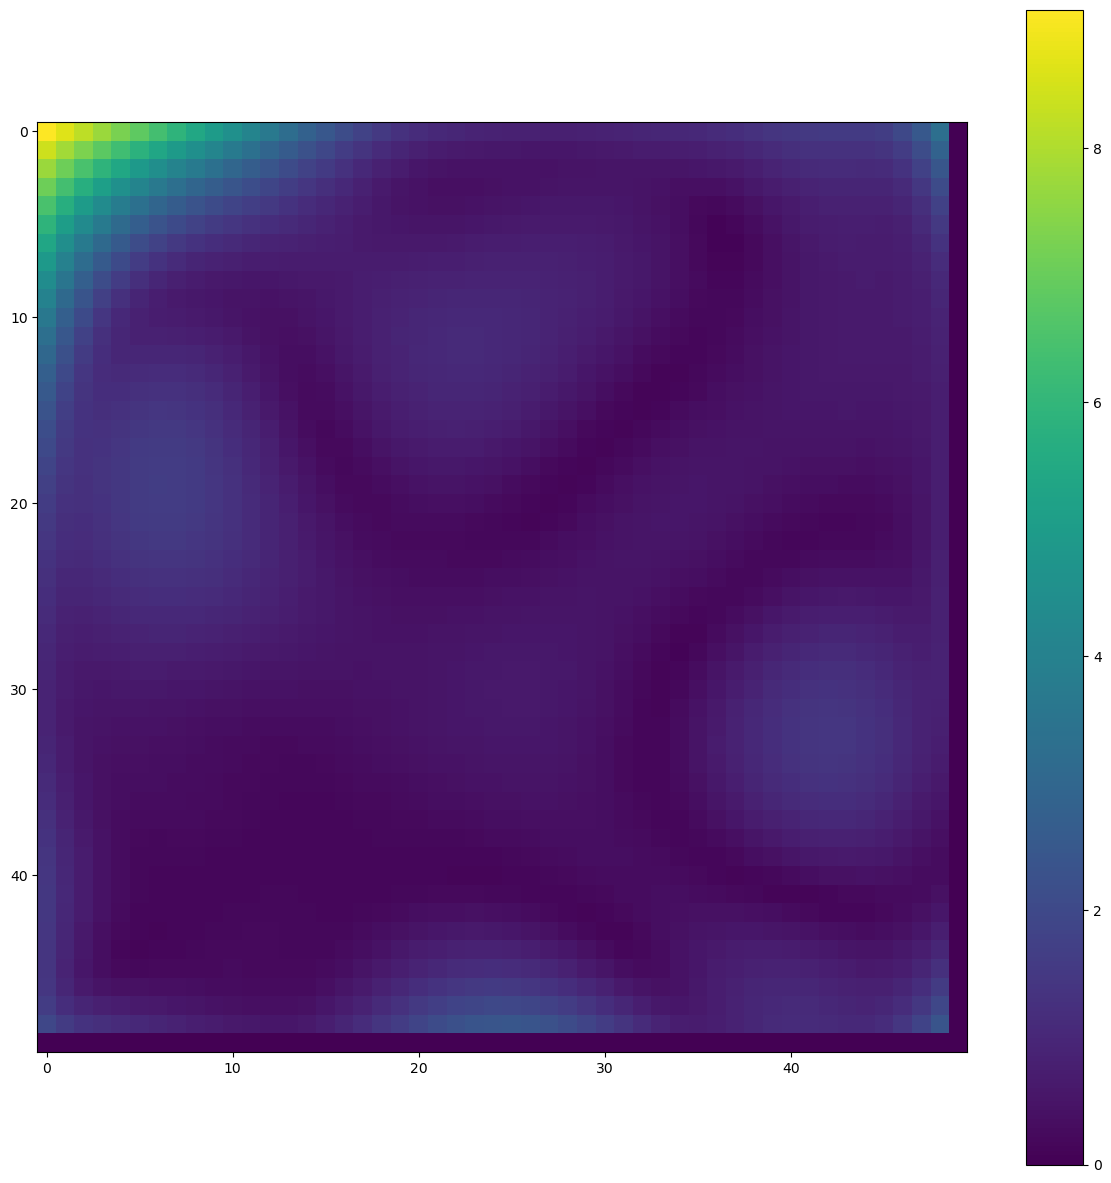

In [26]:
plt.imshow(np.sqrt(sourcesvar))
plt.colorbar()

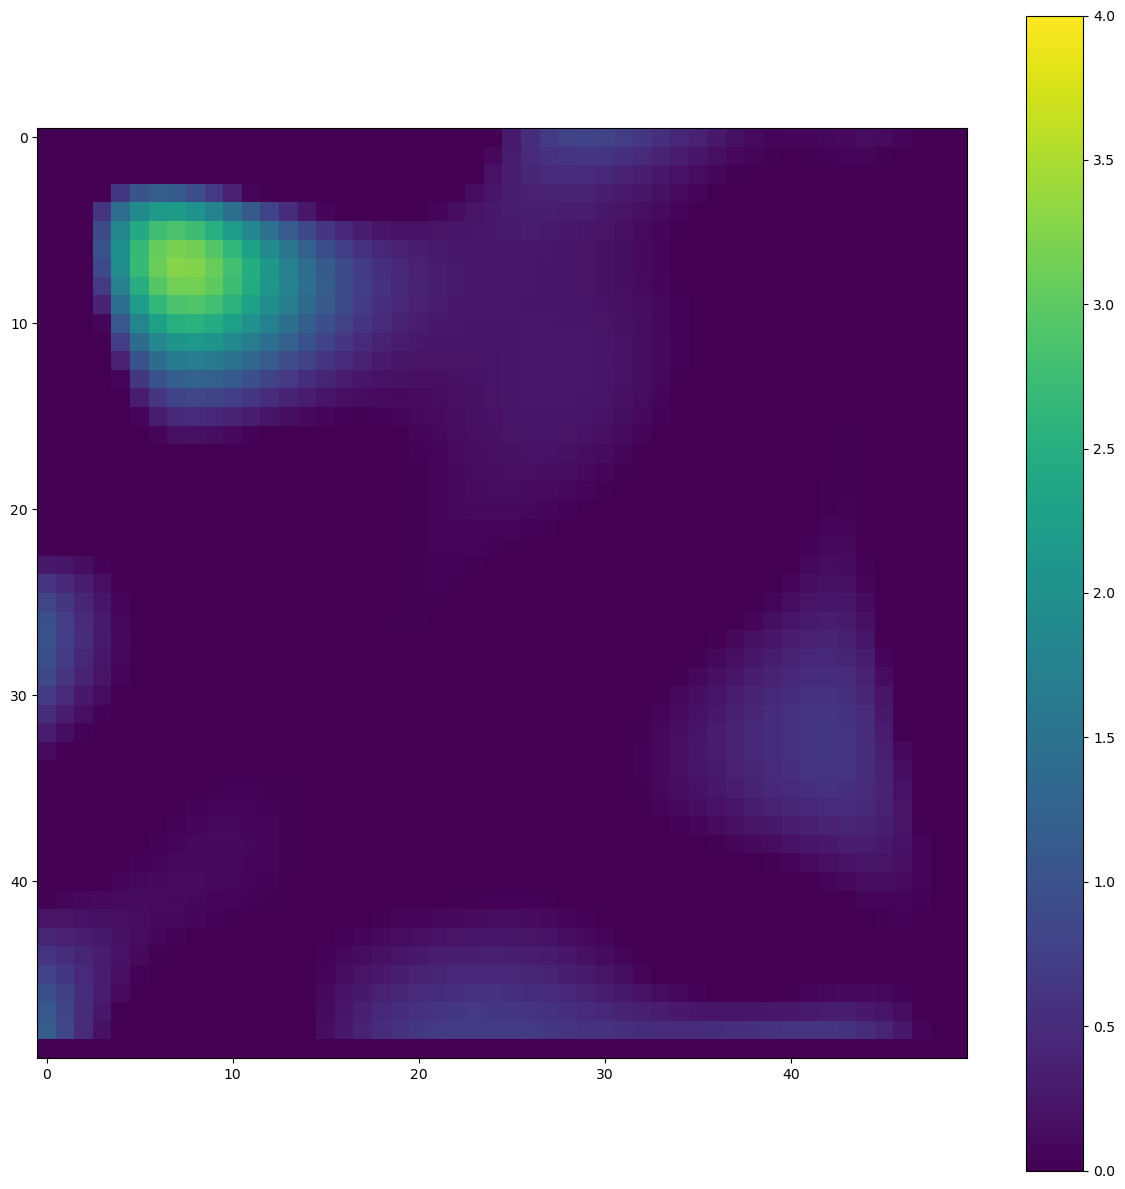

In [23]:

plt.imshow(sourcesmean)
plt.colorbar()
plt.clim([0,4])

In [17]:
#compute concentration grid
#concmean,concvar,concentrations = mMFInfer.computeConcentration(Nparticles=300,
#                                                                   Zs=Zs,interpolateSource=True,
#                                                                   coords=coords)
concmean,concvar,concentrations = mMFInfer.computeConcentration(Nparticles=300,
                                                                   Zs=meanZ,interpolateSource=True,
                                                                   coords=coords)


Initialising particles...
(300, 50, 50, 3)
(300, 300, 50, 50, 3)
Particle shape:
(300, 300, 50, 50, 3)


MemoryError: Unable to allocate 503. GiB for an array with shape (300, 300, 300, 50, 50) and data type float64

In [18]:
Zs = np.random.multivariate_normal(meanZ,covZ,4)
concInfer=mMFInfer.computeConcentration(Zs=Zs) # Generates estimated concentration from inferred source

Initialising particles...
(3, 300, 50, 50)
(30, 3, 300, 50, 50)
Particle shape:


AssertionError: The last dimension of the particles array should be the dimensionality of the domain (e.g. 3 if [time,x,y])

In [ ]:
plot_timeslices(sourceInfer,"Inferred Source")

In [ ]:
plot_timeslices(concInfer,"Inferred Source")